In [1]:
# import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc


In [3]:
import scanpy as sc
import scvelo as scv

# data = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC_level1_rep_cells.h5ad')
data = sc.read('/Users/evanli/Documents/Research_datasets/PBMC_Hao/Hao_PBMC.h5ad')
data.shape

(161764, 20568)

In [4]:
data.shape

(161764, 20568)

In [5]:
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [6]:
data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
types

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

In [7]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Remove_pvl0_v3_ttsplit


In [8]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Remove_pvl0_v3_ttsplit/lambda_decision_ignore_section/v3_feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    print(celltype, 'Feature count:', feature_df.shape[0])
    print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    print('------------------')

B Feature count: 17
B Positive feature count: 9
------------------
CD4_T Feature count: 1786
CD4_T Positive feature count: 36
------------------
CD8_T Feature count: 26
CD8_T Positive feature count: 9
------------------
DC Feature count: 19
DC Positive feature count: 10
------------------
Mono Feature count: 18
Mono Positive feature count: 11
------------------
NK Feature count: 28
NK Positive feature count: 15
------------------
other Feature count: 5
other Positive feature count: 4
------------------
other_T Feature count: 76
other_T Positive feature count: 28
------------------


In [9]:
features_dict.keys()

dict_keys(['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T'])

## LR model for each celltype (e.g. B cells)

In [10]:
celltype = 'B'

# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X  # 17 features for B cells
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

In [16]:
X.shape

(161764, 17)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(129411, 17)
(32353, 17)
129411
32353


In [12]:
clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf.fit(X_train, y_train)

LogisticRegression()

In [13]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
precision = precision_score(y_test, y_pred)  # average='macro'
print("Precision: {:.2f}%".format(precision * 100))
f1 = f1_score(y_test, y_pred)
print("F1: {:.2f}%".format(f1 * 100))

# AUC-ROC
y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print('ROC-AUC:', roc_auc)

Accuracy: 99.91%
Precision: 99.46%
F1: 99.49%
ROC-AUC: 0.9998184059391249


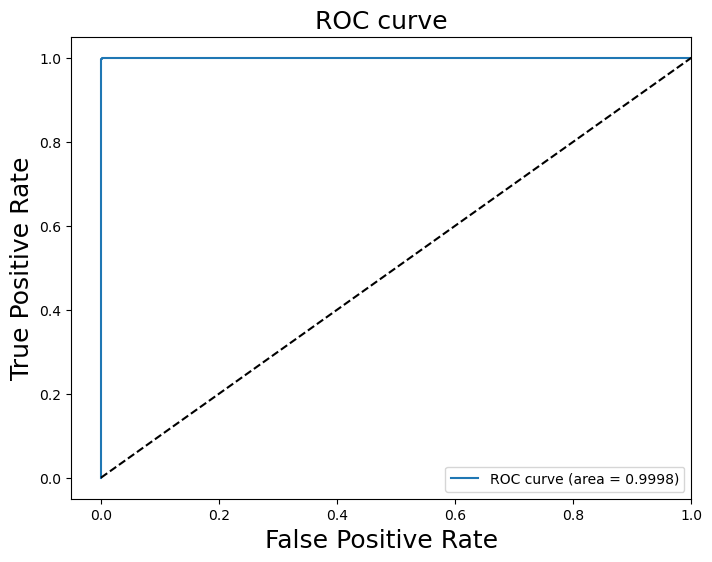

In [14]:
# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()


In [15]:
clf.coef_

array([[-0.16309671,  0.34545244, -0.26263518,  0.34050093,  0.3282183 ,
         0.33953807, -0.09215408,  0.28160108,  0.52394131,  0.04041433,
         3.26845003, -0.29433993,  0.11375673,  0.43580387, -0.17845087,
         0.6867258 ,  0.3060501 ]])

### LR model with only Positive features (B cells)

In [17]:
celltype = 'B'
positive = features_dict[celltype][features_dict[celltype]['Tendency'] == 1]['Gene'].tolist()
# subset data to celltype features
X = data[:, positive].X  # 9 positive features for B cells
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

In [18]:
X.shape

(161764, 9)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

clf_positive = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf_positive.fit(X_train, y_train)

LogisticRegression()

In [20]:
y_pred = clf_positive.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
precision = precision_score(y_test, y_pred)  # average='macro'
print("Precision: {:.2f}%".format(precision * 100))
f1 = f1_score(y_test, y_pred)
print("F1: {:.2f}%".format(f1 * 100))

# AUC-ROC
y_pred_prob = clf_positive.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print('ROC-AUC:', roc_auc)

Accuracy: 99.86%
Precision: 99.35%
F1: 99.18%
ROC-AUC: 0.9998095294764675


### B cells: k-fold CV

In [ ]:
celltype = 'B'

# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X  # 17 features for B cells
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, KFold

clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
# clf.fit(X_train, y_train)

# KFold cross validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)

cross_val_results = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')

In [ ]:
# Print the accuracy for each fold
for i, acc in enumerate(cross_val_results):
    print(f"Fold {i+1}: Accuracy = {acc}")

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(cross_val_results)
print(f"Mean Accuracy: {mean_accuracy:.4f}")

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)

# Perform k-fold cross-validation with multiple metrics
cross_val_results = cross_validate(clf, X, y, cv=kf, scoring=['accuracy', 'precision', 'f1'])


In [ ]:
cross_val_results

In [ ]:
# Calculate and print the mean results across all folds
mean_accuracy = np.mean(cross_val_results['test_accuracy'])
mean_precision = np.mean(cross_val_results['test_precision'])
mean_f1_score = np.mean(cross_val_results['test_f1'])
print(f"Mean Accuracy: {mean_accuracy:.4f}, Mean Precision: {mean_precision:.4f}, Mean F1-score: {mean_f1_score:.4f}")

## Function: LR model for each cell type

### all features

In [21]:
def LR_classifier(data, all_features_dict, celltype):
    print('==================')
    print('Constructing classifier for:', celltype)
    # subset data to celltype features
    celltype_features = all_features_dict[celltype]['Gene'].tolist()
    X = data[:, celltype_features].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)  # average='macro'
    print("Precision: {:.2f}%".format(precision * 100))
    f1 = f1_score(y_test, y_pred)
    print("F1: {:.2f}%".format(f1 * 100))
    # AUC-ROC
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print('ROC-AUC:', roc_auc)

    # model metrics
    metrics = [accuracy, precision, f1, roc_auc]

    return clf, metrics

In [22]:
import pickle
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Remove_pvl0_v3_ttsplit/lambda_decision_ignore_section/classifiers')

all_metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'])
for celltype in types:
    clf, metrics = LR_classifier(data, features_dict, celltype)
    metrics_df = pd.DataFrame([metrics], columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'], index=[celltype])
    all_metrics = pd.concat([all_metrics, metrics_df])
    # print(all_metrics)

    filename = f'LR_{celltype}_l1_a.01.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)

Constructing classifier for: B
(161764, 17)
Accuracy: 99.91%
Precision: 99.46%
F1: 99.49%
ROC-AUC: 0.9998184059391249
Constructing classifier for: CD4_T
(161764, 1786)
Accuracy: 96.23%
Precision: 92.53%
F1: 92.56%
ROC-AUC: 0.9922163029790775
Constructing classifier for: CD8_T
(161764, 26)
Accuracy: 97.10%
Precision: 92.51%
F1: 90.60%
ROC-AUC: 0.9898862174709864
Constructing classifier for: DC
(161764, 19)
Accuracy: 99.68%
Precision: 93.86%
F1: 92.67%
ROC-AUC: 0.9975783142767457
Constructing classifier for: Mono
(161764, 18)
Accuracy: 99.01%
Precision: 97.41%
F1: 98.39%
ROC-AUC: 0.9972389772644474
Constructing classifier for: NK
(161764, 28)
Accuracy: 99.18%
Precision: 96.49%
F1: 96.46%
ROC-AUC: 0.9984656087330349
Constructing classifier for: other
(161764, 5)
Accuracy: 99.05%
Precision: 82.42%
F1: 75.82%
ROC-AUC: 0.8955906262508309
Constructing classifier for: other_T
(161764, 76)
Accuracy: 98.16%
Precision: 84.11%
F1: 76.03%
ROC-AUC: 0.9828004706920994


In [23]:
all_metrics.to_csv('LR_all_features_metrics.csv')

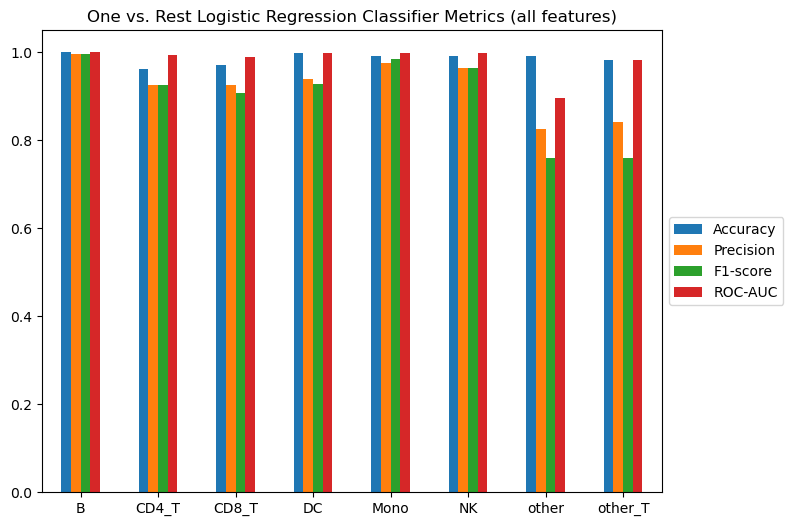

In [24]:
# Plot metrics for each celltype
ax = all_metrics.plot.bar(rot=0, figsize=(8,6), title='One vs. Rest Logistic Regression Classifier Metrics (all features)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### positive features

In [25]:
def LR_positive_classifier(data, all_features_dict, celltype):
    print('==================')
    print('Constructing classifier for:', celltype)
    # subset data to celltype features
    # celltype_features = all_features_dict[celltype]['Gene'].tolist()
    positive = all_features_dict[celltype][all_features_dict[celltype]['Tendency'] == 1]['Gene'].tolist()
    X = data[:, positive].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)  # average='macro'
    print("Precision: {:.2f}%".format(precision * 100))
    f1 = f1_score(y_test, y_pred)
    print("F1: {:.2f}%".format(f1 * 100))
    # AUC-ROC
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print('ROC-AUC:', roc_auc)

    # model metrics
    metrics = [accuracy, precision, f1, roc_auc]

    return clf, metrics

In [26]:
import pickle
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Remove_pvl0_v3_ttsplit/lambda_decision_ignore_section/classifiers_positive')

all_metrics_positive = pd.DataFrame(columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'])
for celltype in types:
    clf, metrics = LR_positive_classifier(data, features_dict, celltype)
    metrics_df = pd.DataFrame([metrics], columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'], index=[celltype])
    all_metrics_positive = pd.concat([all_metrics_positive, metrics_df])
    # print(all_metrics)

    filename = f'LR_positive_{celltype}_l1_a.01.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)

Constructing classifier for: B
(161764, 9)
Accuracy: 99.86%
Precision: 99.35%
F1: 99.18%
ROC-AUC: 0.9998095294764675
Constructing classifier for: CD4_T
(161764, 36)
Accuracy: 87.23%
Precision: 74.39%
F1: 75.01%
ROC-AUC: 0.9443206721782782
Constructing classifier for: CD8_T
(161764, 9)
Accuracy: 96.70%
Precision: 89.61%
F1: 89.49%
ROC-AUC: 0.9870521146212892
Constructing classifier for: DC
(161764, 10)
Accuracy: 99.56%
Precision: 91.37%
F1: 89.88%
ROC-AUC: 0.9972290572349215
Constructing classifier for: Mono
(161764, 11)
Accuracy: 98.28%
Precision: 95.39%
F1: 97.22%
ROC-AUC: 0.9947061072686489
Constructing classifier for: NK
(161764, 15)
Accuracy: 98.72%
Precision: 94.19%
F1: 94.47%
ROC-AUC: 0.9972935308127804
Constructing classifier for: other
(161764, 4)
Accuracy: 99.05%
Precision: 82.45%
F1: 75.92%
ROC-AUC: 0.8985475673750272
Constructing classifier for: other_T
(161764, 28)
Accuracy: 97.84%
Precision: 82.02%
F1: 70.72%
ROC-AUC: 0.9754754496247553


In [27]:
all_metrics_positive.to_csv('LR_positive_all_metrics.csv')

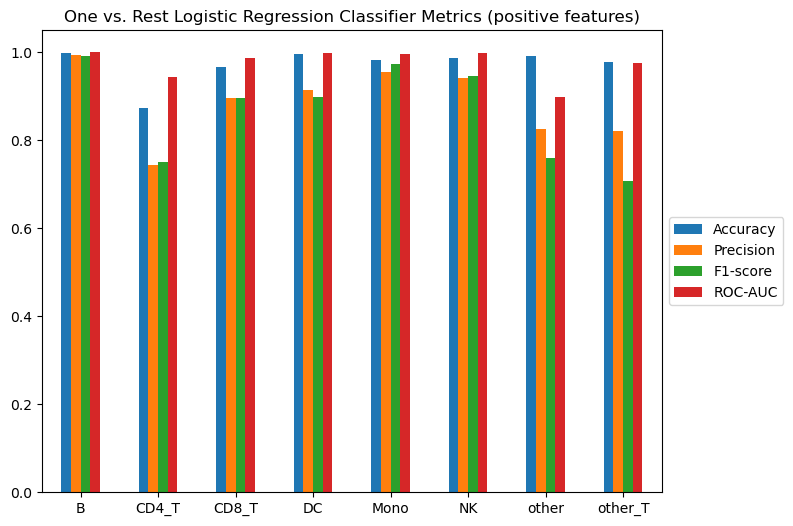

In [29]:
# Plot metrics for each celltype
ax = all_metrics_positive.plot.bar(rot=0, figsize=(8,6), title='One vs. Rest Logistic Regression Classifier Metrics (positive features)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))